In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from bisect import bisect_left

In [16]:
from pathlib import Path

# Assuming Senior-project is in the current working directory path
base_dir = Path.home() / 'Desktop' / 'Senior-project' / 'Ml'

# Define model paths relative to the correct base directory
windmodel = load_model(base_dir / 'wind' / 'WindModel.h5')
nuclearmodel = load_model(base_dir / 'Nukes' / 'NuclearModel.h5')
hydromodel = load_model(base_dir / 'Hydroelectric' / 'HydroModel.h5')
solarmodel = load_model(base_dir / 'solar' / 'SolarModel.h5')
refusemodel = load_model(base_dir / 'Refuse' / 'RefuseModel.h5')
woodmodel = load_model(base_dir / 'wood' / 'WoodModel.h5')

In [17]:
testdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/outputtestdata.csv')
trainingdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')
testdata['Sum'] = testdata['LoadMw']
testdata['BeginDate'] = pd.to_datetime(testdata['BeginDate']).dt.tz_localize(None)
testdata['Previous_Day'] = testdata['BeginDate'] - pd.Timedelta(days=1)
testdata['Previous_2Day'] = testdata['BeginDate'] - pd.Timedelta(days=2)
testdata['Previous_Year'] = testdata['BeginDate'] - pd.DateOffset(years=1)
data2find = testdata[['Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_56400\4199997869.py:2: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  trainingdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')


In [18]:
# Load your data (assuming trainingdata has 'BeginDate', 'Solar', 'Wind', 'Hydro', 'Nuclear' columns)
trainingdata['BeginDate'] = pd.to_datetime(trainingdata['BeginDate']).dt.tz_localize(None)

# Sort trainingdata by BeginDate to allow for efficient nearest date search
trainingdata = trainingdata.sort_values('BeginDate').reset_index(drop=True)

# Initialize an empty list to store results
results = []

# Define a function to find the closest date
def find_nearest_date(date, df):
    """Find the nearest date in the DataFrame for a given date."""
    diffs = (df['BeginDate'] - date).abs()
    nearest_idx = diffs.idxmin()
    return df.loc[nearest_idx]

# Iterate over each row in data2find
for idx, row in data2find.iterrows():
    row_result = {}
    
    # For each renewable type and each previous date, find the nearest date's output
    for energy_type in ['Solar', 'Wind', 'Hydro', 'Nuclear','Wood','Refuse']:
        # Get the nearest data for Previous_Day, Previous_2Day, and Previous_Year
        previous_day_data = find_nearest_date(row['Previous_Day'], trainingdata)
        previous_2day_data = find_nearest_date(row['Previous_2Day'], trainingdata)
        previous_year_data = find_nearest_date(row['Previous_Year'], trainingdata)
        
        # Store the values for each energy type
        row_result[f'Previous_Day_{energy_type}'] = previous_day_data[energy_type]
        row_result[f'Previous_2Day_{energy_type}'] = previous_2day_data[energy_type]
        row_result[f'Previous_Year_{energy_type}'] = previous_year_data[energy_type]
    
    # Append the result to the results list
    results.append(row_result)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)
# Assuming testdata and results_df have the same number of rows
combined_data = pd.concat([testdata.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

# Display the combined DataFrame
print(combined_data.head())



            BeginDate  LoadMw                   datetime  temp   dew  \
0 2024-11-16 05:00:00   10760  2024-11-16 05:00:00+00:00  45.9  19.1   
1 2024-11-16 06:00:00   10400  2024-11-16 06:00:00+00:00  44.8  19.1   
2 2024-11-16 07:00:00   10170  2024-11-16 07:00:00+00:00  45.9  18.1   
3 2024-11-16 08:00:00   10100  2024-11-16 08:00:00+00:00  47.9  18.0   
4 2024-11-16 09:00:00   10240  2024-11-16 09:00:00+00:00  51.2  19.1   

   humidity  precip  preciptype  snow  snowdepth  ...  Previous_Year_Hydro  \
0     34.06       0         NaN     0          0  ...                598.0   
1     35.45       0         NaN     0          0  ...                658.0   
2     32.53       0         NaN     0          0  ...                635.0   
3     30.15       0         NaN     0          0  ...                620.0   
4     27.97       0         NaN     0          0  ...                630.0   

   Previous_Day_Nuclear  Previous_2Day_Nuclear  Previous_Year_Nuclear  \
0                2470.0  

In [19]:
from sklearn.preprocessing import StandardScaler
combined_data['Hour_of_Day'] = combined_data['BeginDate'].dt.hour
combined_data['Minute'] = combined_data['BeginDate'].dt.minute
combined_data['Month'] = combined_data['BeginDate'].dt.month
combined_data['Year'] = combined_data['BeginDate'].dt.year
combined_data['WindSpeedCubed'] = combined_data['windspeed'] ** 3
inputdatahydro = combined_data[['Month','Previous_Day_Hydro','Previous_2Day_Hydro','Sum','Hour_of_Day','Previous_Year_Hydro','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]
inputdatanuclear = combined_data[['Month','Day','Previous_2Day_Nuclear','Sum','Hour_of_Day']]
inputdatawind = combined_data[['WindSpeedCubed','Month','Year','Previous_Year_Wind','Previous_2Day_Wind','Sum','snowdepth','temp','solarenergy','sealevelpressure', 'humidity','solarenergy','snow', 'precip', 'uvindex', 'cloudcover', 'Previous_Day_Wind','Hour_of_Day','dew','windgust','windspeed','winddir']]
inputdatasolar = combined_data[['Month','Year','Previous_Year_Solar','Previous_2Day_Solar','Sum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust']]
inputdatawood = combined_data[['Previous_Day_Wood','Month','Previous_2Day_Wood','Sum','Hour_of_Day','Previous_Year_Wood','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]
inputdatarefuse = combined_data[['Previous_Day_Wood','Month','Previous_2Day_Wood','Sum','Hour_of_Day','Previous_Year_Wood','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]
scalar = StandardScaler()
inputdatahydro = scalar.fit_transform(inputdatahydro)
inputdatanuclear = scalar.fit_transform(inputdatanuclear)
inputdatawind = scalar.fit_transform(inputdatawind)
inputdatasolar = scalar.fit_transform(inputdatasolar)
inputdatawood = scalar.fit_transform(inputdatawood)
inputdatarefuse = scalar.fit_transform(inputdatarefuse)

KeyError: "['Day'] not in index"

In [ ]:
hydropredictions = hydromodel.predict(inputdatahydro)
hydropredictions[hydropredictions < 0] = 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [ ]:
nuclearpredictions = nuclearmodel.predict(inputdatanuclear)
nuclearpredictions[nuclearpredictions < 0] = 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [ ]:
windpredictions = windmodel.predict(inputdatawind)
windpredictions[windpredictions < 0] = 0

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000265A0367560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [ ]:
solarpredictions = solarmodel.predict(inputdatasolar)
solarpredictions[solarpredictions < 0] = 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [ ]:
refusepredictions = refusemodel.predict(inputdatarefuse)
refusepredictions[refusepredictions < 0] = 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [ ]:
woodpredictions = woodmodel.predict(inputdatawood)
woodpredictions[woodpredictions < 0] = 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


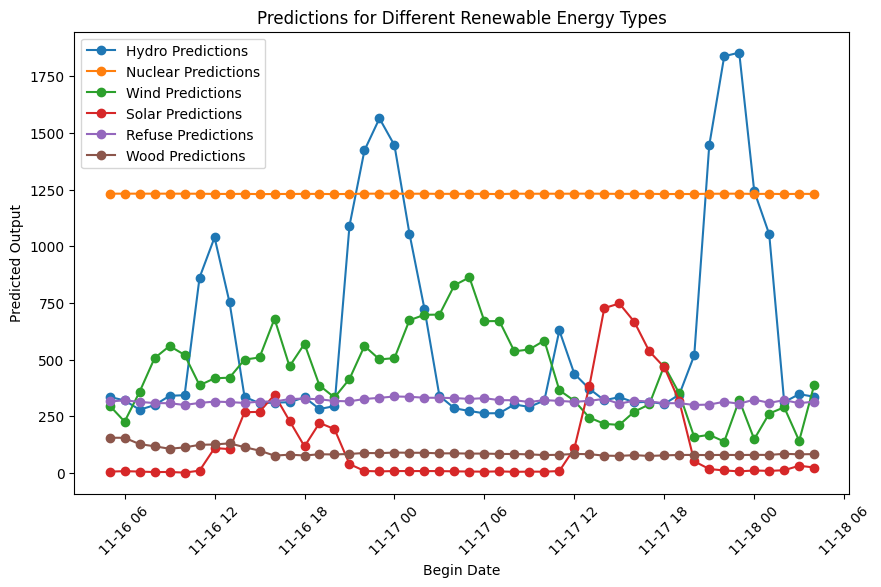

In [ ]:
import matplotlib.pyplot as plt

# Generate the plots
plt.figure(figsize=(10, 6))

# Plot each type of prediction with 'BeginDate' on the x-axis
plt.plot(testdata['BeginDate'], hydropredictions, label='Hydro Predictions', marker='o')
plt.plot(testdata['BeginDate'], nuclearpredictions, label='Nuclear Predictions', marker='o')
plt.plot(testdata['BeginDate'], windpredictions, label='Wind Predictions', marker='o')
plt.plot(testdata['BeginDate'], solarpredictions, label='Solar Predictions', marker='o')
plt.plot(testdata['BeginDate'], refusepredictions, label='Refuse Predictions', marker='o')
plt.plot(testdata['BeginDate'], woodpredictions, label='Wood Predictions', marker='o')

# Add labels and title
plt.xlabel('Begin Date')
plt.ylabel('Predicted Output')
plt.title('Predictions for Different Renewable Energy Types')

# Display legend
plt.legend()

# Rotate x-axis labels for readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()



In [ ]:
# Ensure each prediction variable is a 1D array
hydropredictions = pd.Series(np.array(hydropredictions).ravel())
nuclearpredictions = pd.Series(np.array(nuclearpredictions).ravel())
windpredictions = pd.Series(np.array(windpredictions).ravel())
solarpredictions = pd.Series(np.array(solarpredictions).ravel())
refusepredictions = pd.Series(np.array(refusepredictions).ravel())
woodpredictions = pd.Series(np.array(woodpredictions).ravel())

# Create the DataFrame with BeginDate and all predictions
output_df = pd.DataFrame({
    'BeginDate': testdata['BeginDate'],
    'HydroPredictions': hydropredictions,
    'NuclearPredictions': nuclearpredictions,
    'WindPredictions': windpredictions,
    'SolarPredictions': solarpredictions,
    'RefusePredictions': refusepredictions,
    'WoodPredictions': woodpredictions
})

# Write the DataFrame to a CSV file
output_df.to_csv('energy_predictions.csv', index=False)

print("Predictions successfully saved to 'energy_predictions.csv'")


Predictions successfully saved to 'energy_predictions.csv'


In [ ]:
# Function to find the closest date in the real data for each date in the predictions
def find_closest_date(pred_date, real_dates):
    return real_dates.iloc[(real_dates - pred_date).abs().argsort()[:1]].iloc[0]

# Initialize an empty list to store results
results = []

# Loop over each prediction row
for _, pred_row in output_df.iterrows():
    # Find the closest date in real data
    closest_date = find_closest_date(pred_row['BeginDate'], trainingdata['BeginDate'])
    
    # Get the row with the closest date in the real data
    real_row = trainingdata[trainingdata['BeginDate'] == closest_date].iloc[0]
    
    # Store the predicted and actual values for each energy type
    comparison = {
        'Date': pred_row['BeginDate'],
        'HydroPrediction': pred_row['HydroPredictions'],
        'HydroActual': real_row['Hydro'],
        'NuclearPrediction': pred_row['NuclearPredictions'],
        'NuclearActual': real_row['Nuclear'],
        'WindPrediction': pred_row['WindPredictions'],
        'WindActual': real_row['Wind'],
        'SolarPrediction': pred_row['SolarPredictions'],
        'SolarActual': real_row['Solar'],
        'RefusePrediction': pred_row['RefusePredictions'],
        'RefuseActual': real_row['Refuse'],
        'WoodPrediction': pred_row['WoodPredictions'],
        'WoodActual': real_row['Wood']
    }
    results.append(comparison)

# Convert results to a DataFrame
# Convert results to a DataFrame
# Convert results to a DataFrame
comparison_df = pd.DataFrame(results)

# Drop rows with NaN values, or alternatively, fill NaNs with 0
# Uncomment the following line if you prefer to fill NaNs instead of dropping them
# comparison_df = comparison_df.fillna(0)

import pandas as pd
import numpy as np

# Convert results to a DataFrame
comparison_df = pd.DataFrame(results)

# Drop rows with NaN values, or alternatively, fill NaNs with 0
# Uncomment the following line if you prefer to fill NaNs instead of dropping them
# comparison_df = comparison_df.fillna(0)

# Drop rows with NaN values (if you prefer to drop them)
comparison_df = comparison_df.dropna()

# Calculate the absolute error for each row and each energy type
comparison_df['HydroAbsoluteError'] = abs(comparison_df['HydroPrediction'] - comparison_df['HydroActual'])
comparison_df['NuclearAbsoluteError'] = abs(comparison_df['NuclearPrediction'] - comparison_df['NuclearActual'])
comparison_df['WindAbsoluteError'] = abs(comparison_df['WindPrediction'] - comparison_df['WindActual'])
comparison_df['SolarAbsoluteError'] = abs(comparison_df['SolarPrediction'] - comparison_df['SolarActual'])
comparison_df['RefuseAbsoluteError'] = abs(comparison_df['RefusePrediction'] - comparison_df['RefuseActual'])
comparison_df['WoodAbsoluteError'] = abs(comparison_df['WoodPrediction'] - comparison_df['WoodActual'])

# Calculate the percent error for each row and each energy type
comparison_df['HydroPercentError'] = np.where(comparison_df['HydroActual'] != 0,
                                              abs((comparison_df['HydroPrediction'] - comparison_df['HydroActual']) / comparison_df['HydroActual']) * 100,
                                              np.nan)
comparison_df['NuclearPercentError'] = np.where(comparison_df['NuclearActual'] != 0,
                                                abs((comparison_df['NuclearPrediction'] - comparison_df['NuclearActual']) / comparison_df['NuclearActual']) * 100,
                                                np.nan)
comparison_df['WindPercentError'] = np.where(comparison_df['WindActual'] != 0,
                                             abs((comparison_df['WindPrediction'] - comparison_df['WindActual']) / comparison_df['WindActual']) * 100,
                                             np.nan)
comparison_df['SolarPercentError'] = np.where(comparison_df['SolarActual'] != 0,
                                              abs((comparison_df['SolarPrediction'] - comparison_df['SolarActual']) / comparison_df['SolarActual']) * 100,
                                              np.nan)
comparison_df['RefusePercentError'] = np.where(comparison_df['RefuseActual'] != 0,
                                               abs((comparison_df['RefusePrediction'] - comparison_df['RefuseActual']) / comparison_df['RefuseActual']) * 100,
                                               np.nan)
comparison_df['WoodPercentError'] = np.where(comparison_df['WoodActual'] != 0,
                                             abs((comparison_df['WoodPrediction'] - comparison_df['WoodActual']) / comparison_df['WoodActual']) * 100,
                                             np.nan)

# Calculate the mean absolute error for each energy type
mean_absolute_errors = comparison_df[['HydroAbsoluteError', 'NuclearAbsoluteError', 'WindAbsoluteError', 
                                      'SolarAbsoluteError', 'RefuseAbsoluteError', 'WoodAbsoluteError']].mean()

# Calculate the average percent error for each energy type by averaging row-by-row percent errors
avg_percent_errors = comparison_df[['HydroPercentError', 'NuclearPercentError', 'WindPercentError', 
                                    'SolarPercentError', 'RefusePercentError', 'WoodPercentError']].mean()

# Calculate the total average percent error across all energy types as a single measurement
total_avg_percent_error = (
    abs(
        comparison_df[['HydroPrediction', 'NuclearPrediction', 'WindPrediction', 'SolarPrediction', 'RefusePrediction', 'WoodPrediction']].sum().sum() -
        comparison_df[['HydroActual', 'NuclearActual', 'WindActual', 'SolarActual', 'RefuseActual', 'WoodActual']].sum().sum()
    )
    / comparison_df[['HydroActual', 'NuclearActual', 'WindActual', 'SolarActual', 'RefuseActual', 'WoodActual']].sum().sum()
) * 100

print("Mean Absolute Error for each energy type:")
print(mean_absolute_errors)
print("\nAverage Percent Error for each energy type:")
print(avg_percent_errors)
print("\nTotal Average Percent Error across all energy types:")
print(total_avg_percent_error)


Mean Absolute Error for each energy type:
HydroAbsoluteError       170.834860
NuclearAbsoluteError    2115.064608
WindAbsoluteError        342.942594
SolarAbsoluteError        58.732617
RefuseAbsoluteError       13.866492
WoodAbsoluteError        122.052822
dtype: float64

Average Percent Error for each energy type:
HydroPercentError       44.013644
NuclearPercentError     63.211629
WindPercentError        44.925642
SolarPercentError      138.328738
RefusePercentError       4.196867
WoodPercentError        57.107836
dtype: float64

Total Average Percent Error across all energy types:
46.596936427731634
